In [34]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input # model was pre-processed using this function
from tensorflow.keras.applications.xception import decode_predictions # to decode classes names
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 75.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2

## Loading Dataset from Github

- It's a clothing dataset containing 10 different classes
- Can be used for educational purposes

In [3]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 21.16 MiB/s, done.
Resolving deltas: 100% (10/10), done.


## Checking Example Image from Dataset

In [7]:
# Defining folder locations for dataset

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(150, 150), batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation', target_size=(150, 150), batch_size=32, shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


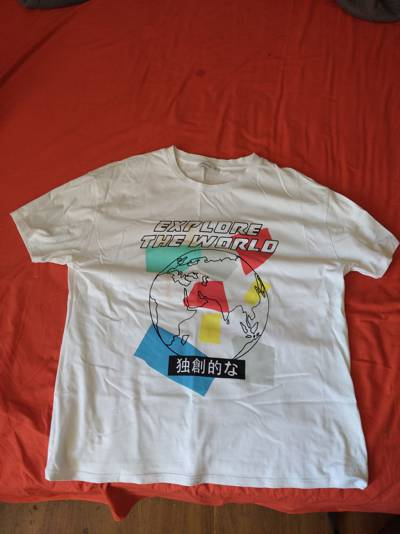

In [4]:
path = './clothing-dataset-small/train/t-shirt/00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg'
load_img(path)

## Using Pre-Trained Xception Model With Transfer Learning on our Dataset
- we are using Xception pre-trained model from keras api

## Adjusting Learning Rate

- Finding Best Param

In [5]:
def make_model(learning_rate=0.01):

  base_model = Xception(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

  base_model.trainable = False

  inputs = keras.Input(shape=(150, 150, 3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  outputs = keras.layers.Dense(10)(vectors)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.CategoricalFocalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])

  return model

In [13]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds)
  scores[lr] = history.history
  print()
  print()

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.3147 - loss: 0.3729 - val_accuracy: 0.6569 - val_loss: 0.1784
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6876 - loss: 0.1615 - val_accuracy: 0.7419 - val_loss: 0.1276
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7434 - loss: 0.1135 - val_accuracy: 0.7566 - val_loss: 0.1091
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8035 - loss: 0.0850 - val_accuracy: 0.7830 - val_loss: 0.0985
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8245 - loss: 0.0752 - val_accuracy: 0.7918 - val_loss: 0.0911
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8499 - loss: 0.0609 - val_accuracy: 0.8035 - val_loss: 0.0879
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8726 - loss: 0.0526 - val_accuracy: 0.8152 - val_loss: 0.0861
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8894 - loss: 0.0459 - val_accuracy: 0

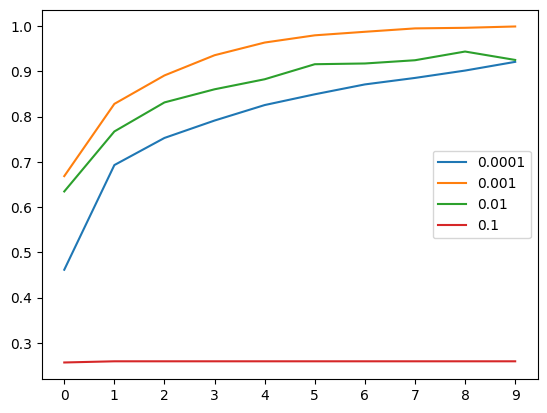

In [14]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

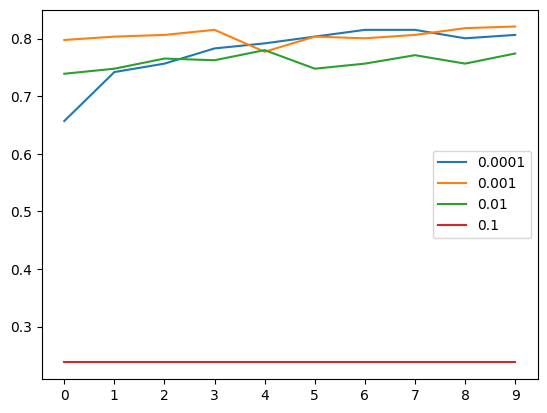

In [15]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

Best learning rate seems to be 0.001

## Adjusting and Finding Best Inner Layer Size

In [16]:
def make_model(learning_rate=0.01, size_inner=100):

  base_model = Xception(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

  base_model.trainable = False

  # Defining Layers
  inputs = keras.Input(shape=(150, 150, 3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  outputs = keras.layers.Dense(10)(inner)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.CategoricalFocalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])

  return model

In [17]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 500, 1000]:
  print(size)
  model = make_model(learning_rate=learning_rate, size_inner=size)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds)
  scores[size] = history.history
  print()
  print()

10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.3060 - loss: 0.3593 - val_accuracy: 0.6217 - val_loss: 0.1832
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6743 - loss: 0.1487 - val_accuracy: 0.7214 - val_loss: 0.1256
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7534 - loss: 0.1017 - val_accuracy: 0.7419 - val_loss: 0.1165
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7773 - loss: 0.0854 - val_accuracy: 0.7449 - val_loss: 0.1092
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8223 - loss: 0.0713 - val_accuracy: 0.7654 - val_loss: 0.1057
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8301 - loss: 0.0608 - val_accuracy: 0.7654 - val_loss: 0.1024
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8716 - loss: 0.0490 - val_accuracy: 0.7713 - val_loss: 0.1030
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8944 - loss: 0.0388 - val_accuracy: 0.774

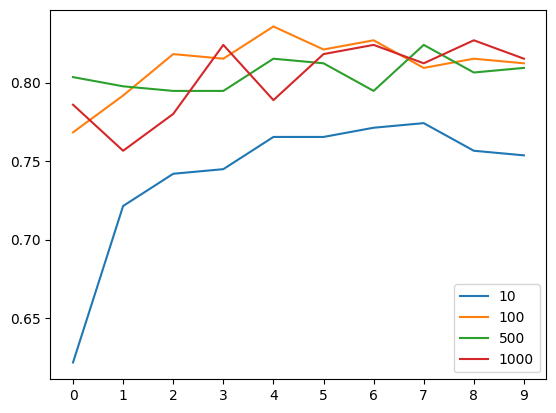

In [18]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=size)

plt.xticks(np.arange(10))
plt.legend()

100 Seems to be stable here.

## Finding Best Dropout Rate

In [19]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):

  base_model = Xception(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

  base_model.trainable = False

  # Defining Layers
  inputs = keras.Input(shape=(150, 150, 3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.CategoricalFocalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])

  return model

In [20]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
  print(droprate)

  model = make_model(learning_rate=learning_rate,
                     size_inner=size,
                     droprate=droprate)

  history = model.fit(train_ds, epochs=30, validation_data=val_ds) # since we are adding regularization and dropout, it needs more epochs to learn
  scores[droprate] = history.history
  print()
  print()



0.0
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.5777 - loss: 0.2224 - val_accuracy: 0.8094 - val_loss: 0.0886
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8296 - loss: 0.0628 - val_accuracy: 0.7977 - val_loss: 0.0972
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8893 - loss: 0.0347 - val_accuracy: 0.8270 - val_loss: 0.0793
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9409 - loss: 0.0194 - val_accuracy: 0.8094 - val_loss: 0.0778
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9594 - loss: 0.0124 - val_accuracy: 0.7947 - val_loss: 0.1006
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9785 - loss: 0.0090 - val_accuracy: 0.8123 - val_loss: 0.0848
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9910 - loss: 0.0042 - val_accuracy: 0.8152 - val_loss: 0.0890
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9959 - loss: 0.0030 - val_accuracy: 0.80

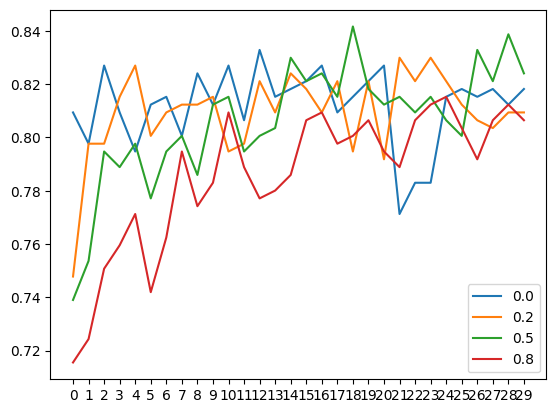

In [21]:
for droprate, hist in scores.items():
  plt.plot(hist['val_accuracy'], label=droprate)

plt.xticks(np.arange(30))
plt.legend()

Droprate seems unstable at many points, the rate of 0.2 seems like a viable choice here.

## Training Final Model on 299x299 Resolution with Data Augmentation

In [22]:
def make_model(input_size=299, learning_rate=0.001, size_inner=100, droprate=0.2): 

  base_model = Xception(weights='imagenet',
                        include_top=False,
                        input_shape=(input_size, input_size, 3))

  base_model.trainable = False

  # Defining Layers
  inputs = keras.Input(shape=(input_size, input_size, 3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.CategoricalFocalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])

  return model

In [23]:
input_size = 299

In [24]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 10, # with added data augmentation
    zoom_range = 0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [25]:
# checkpointing and saving the best model

checkpoint = keras.callbacks.ModelCheckpoint(
    'cnn_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [26]:
model = make_model() # arugments already linked to default in function definiton

history = model.fit(train_ds, 
                    epochs=50,  # training 50 epochs since we have dropout, augmentation and higher res
                    validation_data=val_ds, 
                    callbacks=[checkpoint])
print()
print()

Epoch 1/50


2025-05-14 11:51:47.405076: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-14 11:51:47.438252: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.033371363s
Trying algorithm eng3{k11=2} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone

93/96 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - accuracy: 0.6131 - loss: 0.1984

E0000 00:00:1747223572.678635     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747223572.919860     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747223574.087808     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747223574.356165     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.6168 - loss: 0.1961

E0000 00:00:1747223585.923244     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747223586.162068     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747223586.746158     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747223587.009084     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


96/96 ━━━━━━━━━━━━━━━━━━━━ 93s 821ms/step - accuracy: 0.6179 - loss: 0.1953 - val_accuracy: 0.8563 - val_loss: 0.0522
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 629ms/step - accuracy: 0.8439 - loss: 0.0594 - val_accuracy: 0.8592 - val_loss: 0.0471
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 626ms/step - accuracy: 0.8644 - loss: 0.0471 - val_accuracy: 0.8651 - val_loss: 0.0449
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 615ms/step - accuracy: 0.8911 - loss: 0.0368 - val_accuracy: 0.8651 - val_loss: 0.0505
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 626ms/step - accuracy: 0.8825 - loss: 0.0350 - val_accuracy: 0.8563 - val_loss: 0.0458
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 625ms/step - accuracy: 0.9054 - loss: 0.0293 - val_accuracy: 0.8680 - val_loss: 0.0479
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 622ms/step - accuracy: 0.9158 - loss: 0.0238 - val_accuracy: 0.8563 - val_loss: 0.0450
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 614ms/step - accuracy: 0.9129 - loss: 0.0241 - val_accuracy: 0.865

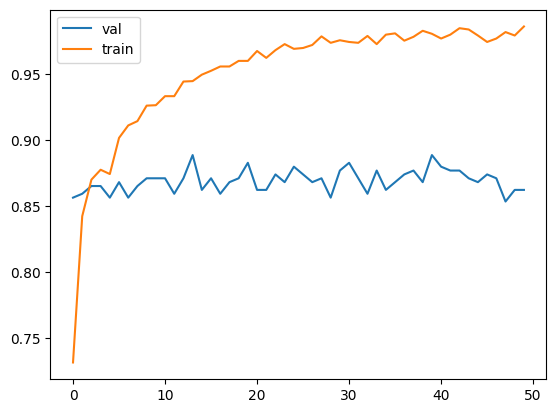

In [27]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
plt.legend()

## Testing on Test Dataset

In [30]:
model = keras.models.load_model('/kaggle/working/cnn_14_0.889.h5')

In [31]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [32]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.8614 - loss: 0.0494


[0.03412729501724243, 0.897849440574646]

Accuracy on test dataset is 89%, which is good.

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step
Accuracy: 0.8978
Classification Report:
              precision    recall  f1-score   support

       dress       0.78      0.93      0.85        15
         hat       1.00      1.00      1.00        12
  longsleeve       0.89      0.75      0.81        72
     outwear       0.87      0.87      0.87        38
       pants       0.93      1.00      0.97        42
       shirt       0.72      0.81      0.76        26
       shoes       1.00      0.99      0.99        73
      shorts       0.96      0.90      0.93        30
       skirt       1.00      0.75      0.86        12
     t-shirt       0.83      0.96      0.89        52

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.89       372
weighted avg       0.90      0.90      0.90       372



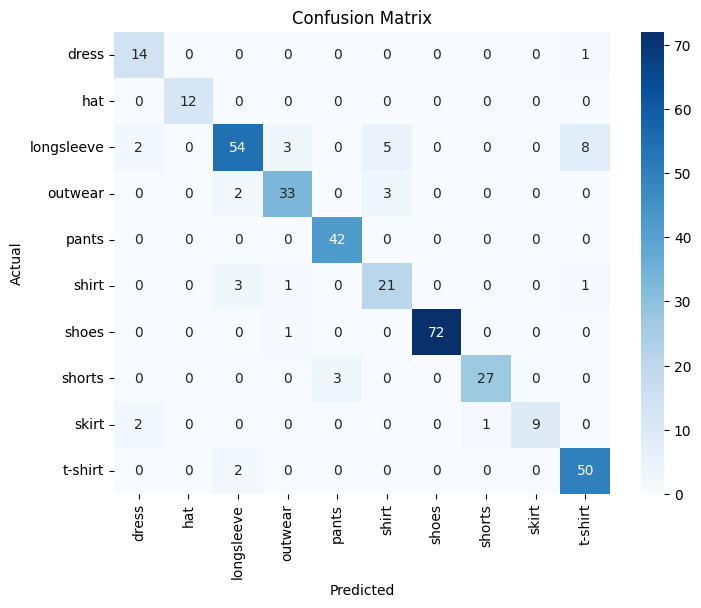

In [35]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_ds.classes  # actual class indices

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

class_labels = list(test_ds.class_indices.keys())  # get class names from directory
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
